# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\ASUS\Miniconda3\python.exe -m pip install --upgrade pip


In [3]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
abstract_singleton            1.0.1
addict                        2.4.0
aiofiles                      22.1.0
aiohttp                       3.8.4
aiosignal                     1.3.1
aiosqlite                     0.18.0
albumentations                1.3.1
altair                        5.0.1
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.2.1
astunparse                    1.6.3
async-generator               1.10
async-timeout                 4.0.2
asynctest                     0.13.0
attrs                         22.1.0
auto_gpt_plugin_template      0.0.3
autoflake                     2.1.1
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
basicsr                       1.4.2
beautifuls


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\ASUS\Miniconda3\python.exe -m pip install --upgrade pip


In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

In [8]:
data_dir = 'data' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

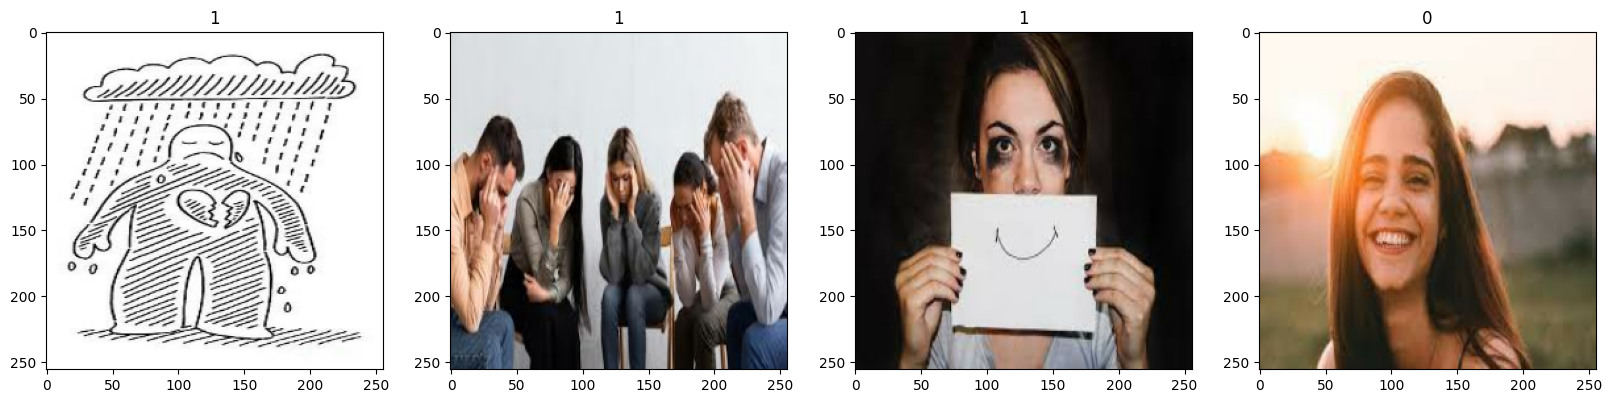

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
data.as_numpy_iterator().next()

(array([[[[9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          [9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          [9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          ...,
          [2.66677320e-01, 1.68638095e-01, 9.02067274e-02],
          [3.40246230e-01, 2.42207006e-01, 1.63775638e-01],
          [3.30964327e-01, 2.48611391e-01, 1.66258454e-01]],
 
         [[9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          [9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          [9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          ...,
          [4.14921790e-01, 3.16882551e-01, 2.38451198e-01],
          [3.10689896e-01, 2.12650672e-01, 1.34219304e-01],
          [3.21703136e-01, 2.35428631e-01, 1.53075695e-01]],
 
         [[9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          [9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          [9.72549021e-01, 9.72549021e-01, 9.72549021e-01],
          ...,
          [3.18314612e-01, 2.20275402e-01, 1.4184

# 5. Split Data

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train_size

7

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [21]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 7s 844ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 2/20
7/7 [==============================] - 7s 816ms/step - loss: 0.0125 - accuracy: 0.9955 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 7s 846ms/step - loss: 0.0102 - accuracy: 0.9955 - val_loss: 0.0316 - val_accuracy: 0.9844
Epoch 4/20
7/7 [==============================] - 7s 825ms/step - loss: 0.0178 - accuracy: 0.9911 - val_loss: 0.0228 - val_accuracy: 0.9844
Epoch 5/20
7/7 [==============================] - 7s 824ms/step - loss: 0.0108 - accuracy: 0.9955 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 7s 854ms/step - loss: 0.0075 - accuracy: 0.9955 - val_loss: 6.6769e-04 - val_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 7s 894ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 8/20
7/7 [

# 8. Plot Performance

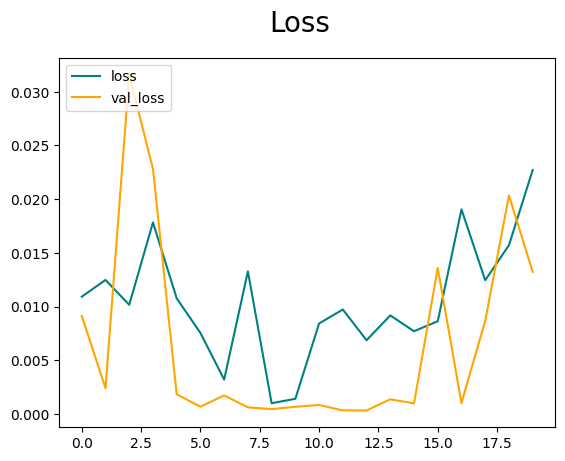

In [38]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

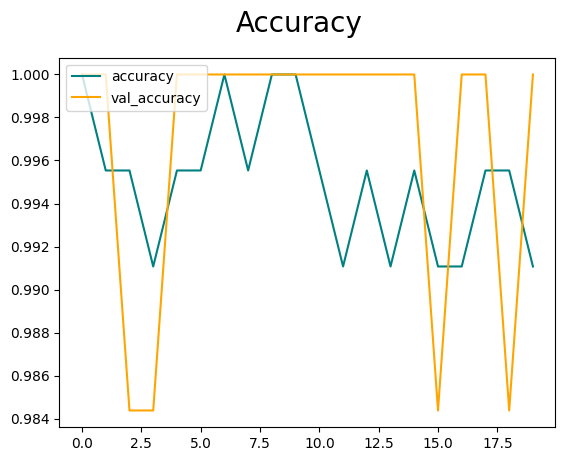

In [39]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [40]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [41]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [42]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 82ms/step


In [43]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [44]:
import cv2

TypeError: Image data of dtype object cannot be converted to float

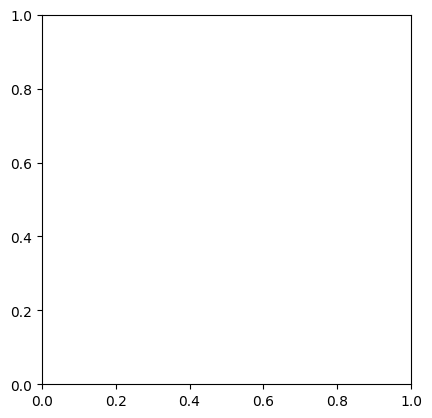

In [71]:
img = cv2.imread('1132928286.jpeg')
plt.imshow(img)
plt.show()

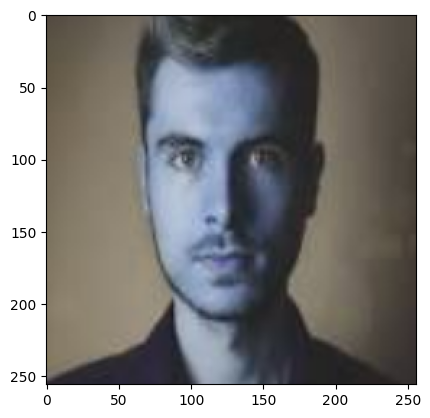

In [68]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [69]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 30ms/step


In [70]:
yhat

array([[0.925072]], dtype=float32)

In [49]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [53]:
from tensorflow.keras.models import load_model

In [57]:
model.save(os.path.join('models','imageclassifier.h5'))

In [60]:
new_model = load_model('models/imageclassifier.h5')

In [61]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 78ms/step


array([[0.0154231]], dtype=float32)